In [17]:
import os.path as osp
import dotenv
import pandas as pd
import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

In [18]:
from snorkel.models import candidate_subclass

InducingCytokine = candidate_subclass('InducingCytokine', ['cytokine', 'cell_type'])
train_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 0).all()
dev_cands = session.query(InducingCytokine).filter(InducingCytokine.split == 1).all()

In [20]:
len(train_cands), len(dev_cands)

(4334, 120)

In [21]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

In [27]:
??rule_regex_search_before_A

In [25]:
train_cands[0].get_parent()

Sentence(Document PMC5691654,153,b'The controversial requirement of TGF-\xce\xb2 in Th17 differentiation was further highlighted in human studies.')

In [22]:
get_tagged_text(train_cands[0])

'The controversial requirement of {{A}} in {{B}} differentiation was further highlighted in human studies.'

In [38]:
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce_between(c):
    ptn = ltp(['induces', 'induced'])
    return 1 if re.search(r'{{A}}.*' + ptn + '.*{{B}}', get_tagged_text(c), flags=re.I) else 0

def LF_differentiation_after(c):
    ptn = ltp(['differentiation', 'differentiated'])
    return 1 if re.search(r'{{A}}.*{{B}}.{0.30}' + ptn, get_tagged_text(c), flags=re.I) else 0

def LF_induce_between_differentiation_after(c):
    return LF_induce_between(c) * LF_differentiation_after(c)

def LF_drive_differentiation(c):
    ptn1 = ltp(['drives', 'driven'])
    ptn2 = ltp(['differentiation', 'differentiated'])
    return 1 if re.search(r'{{A}}.{0,20}' + ptn1 + '.{0,20}{{B}}.{0.20}' + ptn2, get_tagged_text(c), flags=re.I) else 0

def LF_before_max_dist(c):
    return 1 if re.search(r'{{A}}.{0,100}{{B}}', get_tagged_text(c), flags=re.I) else 0


In [39]:
LFs = [
    LF_induce_between,
    LF_differentiation_after,
    LF_induce_between_differentiation_after,
    LF_drive_differentiation,
    LF_before_max_dist,
]

In [40]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [41]:
%time L_train = labeler.apply(split=0)
L_train

  0%|          | 20/4334 [00:00<00:22, 195.24it/s]

Clearing existing...
Running UDF...


100%|██████████| 4334/4334 [00:15<00:00, 287.88it/s]


CPU times: user 15 s, sys: 133 ms, total: 15.1 s
Wall time: 15.1 s


<4334x5 sparse matrix of type '<class 'numpy.int64'>'
	with 1471 stored elements in Compressed Sparse Row format>

In [42]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_induce_between,0,0.015459,0.007845,0.0
LF_differentiation_after,1,0.000000,0.000000,0.0
LF_induce_between_differentiation_after,2,0.000000,0.000000,0.0
LF_drive_differentiation,3,0.000000,0.000000,0.0
LF_before_max_dist,4,0.323950,0.007845,0.0


## Train Generative Model

In [43]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

10

In [44]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [45]:
train_marginals = gen_model.marginals(L_train)

In [46]:
train_marginals.shape

(4334,)

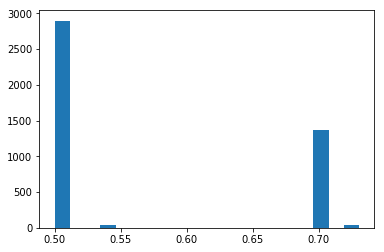

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [49]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.643641,0.1549,0.645995,0.101133
1,0.631303,0.1527,0.626788,0.097492
2,0.648964,0.1544,0.662180,0.099515
3,0.639398,0.1528,0.652058,0.099312
4,0.711850,0.3460,0.718622,0.248989


In [50]:
from snorkel.annotations import save_marginals
save_marginals(session, L_train, train_marginals)

Saved 4334 marginals


## Check Against Dev Labels

In [104]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True)
# Labels return as 0 when a candidate has no gold label loaded but in this case,
# unlabeled candidates in the dev set are to be treated as negative instances
L_gold_dev = np.where(L_gold_dev == 1, 1, -1)
assert np.all(np.in1d(L_gold_dev, [-1, 1]))
L_gold_dev[:100]

array([-1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
        1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1, -1, -1, -1,  1, -1,
       -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1])

In [52]:
L_dev = labeler.apply_existing(split=1)

 18%|█▊        | 21/120 [00:00<00:00, 203.22it/s]

Clearing existing...
Running UDF...


100%|██████████| 120/120 [00:00<00:00, 235.42it/s]


In [101]:
pd.DataFrame(L_dev.toarray()).assign(label=L_gold_dev).head()

,0,1,2,3,4,label
0,0,0,0,0,0,-1
1,0,0,0,0,0,-1
2,0,0,0,0,1,1
3,0,0,0,0,1,-1
4,0,0,0,0,0,-1


In [99]:
_ = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.708
Neg. class accuracy: 0.771
Precision            0.436
Recall               0.708
F1                   0.54
----------------------------------------
TP: 17 | FP: 22 | TN: 74 | FN: 7



In [100]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

/Users/eczech/anaconda3/envs/snorkel/lib/python3.6/site-packages/snorkel/annotations.py:137: RuntimeWarning: invalid value encountered in true_divide
  ac = (tp+tn) / (tp+tn+fp+fn)


,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_induce_between,0,0.008333,0.0,0.0,0,1,0,0,0.000000,0.641270
LF_differentiation_after,1,0.000000,0.0,0.0,0,0,0,0,NaN,0.652625
LF_induce_between_differentiation_after,2,0.000000,0.0,0.0,0,0,0,0,NaN,0.647327
LF_drive_differentiation,3,0.000000,0.0,0.0,0,0,0,0,NaN,0.631918
LF_before_max_dist,4,0.316667,0.0,0.0,17,21,0,0,0.447368,0.715929
